# Machine Learning

Arne Huckemann (ahuckema), Elise Wolf (eliwolf)

In [134]:
import numpy as np
import scipy
import scipy.stats
import matplotlib.pyplot as plt
from IPython import get_ipython
from numpy.linalg import svd
from util import nextplot, plot_xy
from sklearn.cluster import KMeans

# setup plotting
import psutil
inTerminal = not "IPKernelApp" in get_ipython().config
inJupyterNb = any(filter(lambda x: x.endswith("jupyter-notebook"), psutil.Process().parent().cmdline()))
inJupyterLab = any(filter(lambda x: x.endswith("jupyter-lab"), psutil.Process().parent().cmdline()))
if not inJupyterLab:
    from IPython import get_ipython
    get_ipython().run_line_magic("matplotlib", "" if inTerminal else "notebook" if inJupyterNb else "widget")

# 1 Probabilistic PCA

## 1a) Toy data

In [135]:
# You do not need to modify this method.
def ppca_gen(N=10000, D=2, L=2, sigma2=0.5, mu=None, lambda_=None, Q=None, seed=None):
    """Generate data from a given PPCA model.

    Unless specified otherwise, uses a fixed mean, fixed eigenvalues (variances along
    principal components), and a random orthogonal eigenvectors (principal components).

    """

    # determine model parameters (from arguments or default)
    rng = np.random.RandomState(seed)
    if mu is None:
        mu = np.arange(D) + 1.0
    if Q is None:
        Q = scipy.stats.ortho_group.rvs(D, random_state=rng)
    if lambda_ is None:
        lambda_ = np.arange(D, 0, -1) * 2

    # weight matrix is determined from first L eigenvectors and eigenvalues of
    # covariance matrix
    Q_L = Q[:, :L]
    lambda_L = lambda_[:L]
    W = Q_L * np.sqrt(lambda_L)  # scales columns

    # generate data
    Z = rng.standard_normal(size=(N, L))  # latent variables
    Eps = rng.standard_normal(size=(N, D)) * np.sqrt(sigma2)  # noise
    X = Z @ W.transpose() + mu + Eps  # data points

    # all done
    return dict(
        N=N, D=D, L=L, X=X, Z=Z, mu=mu, Q_L=Q_L, lambda_L=lambda_L, W=W, Eps=Eps
    )

This function simulates data that follows the PPCA model.

- N: Number of data points to generate.
- D: Dimensionality of the observed data.
- L: Number of principal components (latent variables).
- sigma2: Variance of the noise.
- mu: Mean of the data. If not provided, it defaults to a fixed mean.
- lambda_: Eigenvalues (variances along principal components). If not provided, it defaults to a fixed set of eigenvalues.
- Q: Orthogonal matrix of eigenvectors (principal components). If not provided, it generates a random orthogonal matrix.

Returns additionally
- W: Weight matrix calculated by scaling the columns of Q_L by the square root of lambda_L.
- Eps: Noise generated from a standard normal distribution of size N x D, scaled by the square root of sigma2.
- X: Observed data points calculated as the product of Z and the transpose of W, added to the mean mu and noise Eps.


In [136]:
# You do not need to modify this method.
def ppca_plot_2d(data, X="X", mu="mu", W="W", alpha=0.05, axis=None, **kwargs):
    """Plot 2D PPCA data along with its weight vectors."""
    if not axis:
        nextplot()
        axis = plt.gca()
    X = data[X] if isinstance(X, str) else X
    plot_xy(X[:, 0], X[:, 1], alpha=alpha, axis=axis, **kwargs)

    # additional plot elements: mean and components
    if mu is not None:
        mu = data[mu] if isinstance(mu, str) else mu
        if W is not None:
            W = data[W] if isinstance(W, str) else W
            head_width = np.linalg.norm(W[:, 0]) / 10.0
            for j in range(W.shape[1]):
                axis.arrow(
                    mu[0],
                    mu[1],
                    W[0, j],
                    W[1, j],
                    length_includes_head=True,
                    head_width=head_width,
                )

273244.39906464086
[[1.74885766]
 [0.97030762]]
[1. 2.]


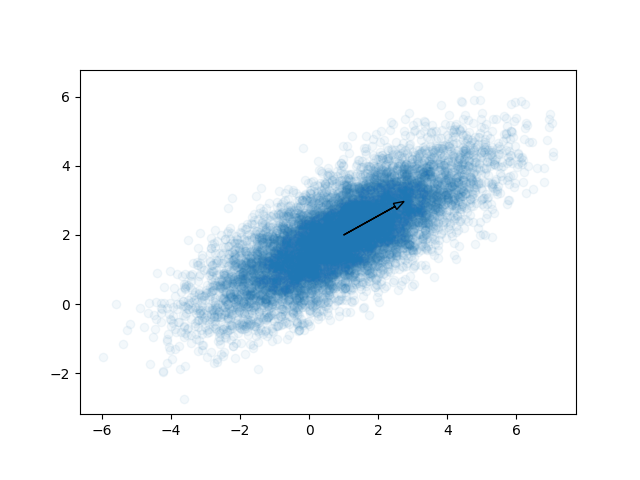

In [137]:
# Generate and plot a toy dataset
toy_ppca = ppca_gen(L=1, sigma2=0.5, seed=0)
ppca_plot_2d(toy_ppca)
print(np.sum(toy_ppca["X"] ** 3))  # must be 273244.3990646409
print(toy_ppca['W'])
print(toy_ppca['mu'])

This function `ppca_gen` generates a 2-dimensional scatter plot of 10000 data points that are diagonally distributed along its weight vector [1.74885766, 0.97030762] for the first principal component. The data points are mainly between -2 and 4 on the x-axis and 0 and 4 on the y-axis. The noise is set through the variance 0.5 and the mean of the data is [1, 2].

The diagonal distribution of the points along the vector reflects the underlying structure captured by the probabilistic PCA model.

### Impact of Noise

[[1.74885766]
 [0.97030762]]
[1. 2.]


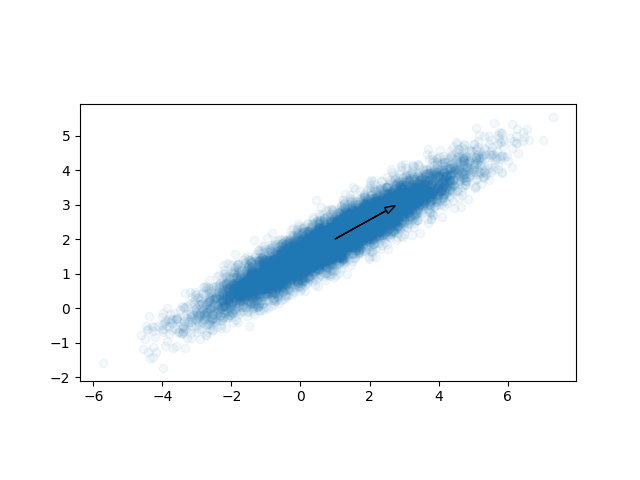

In [138]:
# Generate and plot a toy dataset
toy_ppca_2 = ppca_gen(L=1, sigma2=0.1, seed=0)
print(toy_ppca_2 ['W'])
print(toy_ppca_2 ['mu'])
ppca_plot_2d(toy_ppca_2)

This function `ppca_gen` generates a 2-dimensional scatter plot of 10000 data points that are diagonally distributed along its weight vector [1.74885766, 0.97030762] for the first principal component. The noise is set through the variance 0.1 and the mean of the data is [1, 2].

The difference in the noise points variance influenced the plot by altering the spread of the data points around the principal component. With a lower noise variance ($\sigma^2$ = 0.1), the data points are more tightly clustered along the weight vector, resulting in a narrower distribution. This compression is evident as the points mainly lie between -2 and 6 on the x-axis and 0 and 4 on the y-axis. The reduced noise variance introduces less randomness, making the points adhere more closely to the underlying structure captured by the probabilistic PCA model. 
The diagonal distribution of the points along the vector reflects the underlying structure captured by the probabilistic PCA model.

The variance of the noise points in a probabilistic PCA model influences the spread of the data points around the principal component. Since variance measures the spread of the data points. A higher variance means the data points are more spread out, while a lower variance means they are more tightly clustered around the mean. The points are more aligned along the principal component, making the diagonal distribution clearer. 


[[1.74885766]
 [0.97030762]]
[1. 2.]


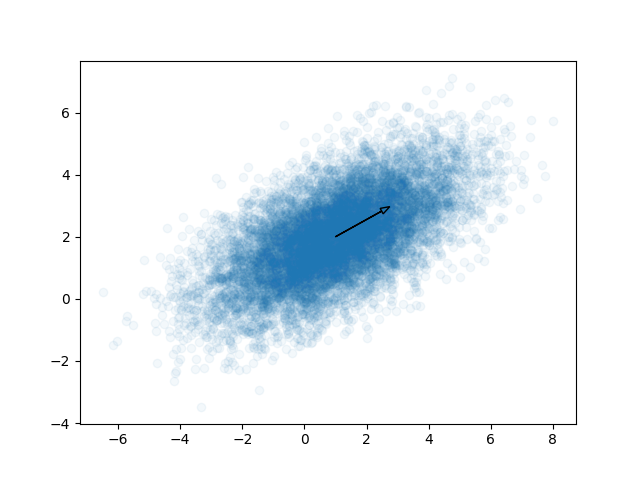

In [139]:
# Generate and plot a toy dataset
toy_ppca_3 = ppca_gen(L=1, sigma2=1, seed=0)
print(toy_ppca_3 ['W'])
print(toy_ppca_3 ['mu'])
ppca_plot_2d(toy_ppca_3)

This function `ppca_gen` generates a 2-dimensional scatter plot of 10000 data points that are diagonally distributed along its weight vector [1.74885766, 0.97030762] for the first principal component. The noise is set through the variance 1.0 and the mean of the data is [1, 2].

The difference in the noise points variance influenced the plot by altering the spread of the data points around the principal component. With a higher noise variance ($\sigma^2$ = 1.0), the data points are much more spread out and less compressed regarding the orthogonal direction of the weight vector. This is evident as the points mainly lie between -2 and 4 on the x-axis and 0 and 4 on the y-axis. Compared to the first plot, the data points are concentrated within the same x and y axis parts but are more spread out and not densely near the weight vector anymore. The increased noise variance introduces more randomness, making the points deviate further from the underlying structure captured by the probabilistic PCA model.

The variance of the noise points in a probabilistic PCA model influences the spread of the data points around the principal component. Since variance measures the spread of the data points, a higher variance means the data points are more spread out, while a lower variance means they are more tightly clustered around the mean. The points are less aligned along the principal component, making the diagonal distribution less clear.

In summary, different variance leads to:
- For $\sigma^2$ = 0.1, the data points are closely packed along the diagonal vector.
- For $\sigma^2$ = 0.5, the data points are more spread out but still follow the diagonal trend.
- For $\sigma^2$ = 1.0, the data points are even more dispersed, showing a broader distribution around the diagonal vector.

These observations illustrate how the noise variance impacts the data distribution in probabilistic PCA.

## 1b) Maximum Likelihood Estimation

In [140]:
def ppca_mle(X, L):
    """Computes the ML estimates of PPCA model parameters.

    Returns a dictionary with keys `mu`, `W`, and `sigma2` and the corresponding ML
    estimates as values.

    """
    N, D = X.shape

    # Compute the ML estimates of the PPCA model parameters: mu_mle, sigma2_mle (based
    # on mu_mle), and W_mle (based on mu_mle and sigma2_mle). In your code, only use
    # standard matrix/vector operations and svd(...).
    # YOUR CODE HERE
    
    # calculate mean of the data and center data
    mu_mle = np.mean(X, axis=0)
    X_centered = X - mu_mle

    # SVD
    U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)
    V = Vt.T
    eigenvalues = (S**2) / (N)  # eigenvalues of the covariance matrix

    
    # calculate W and sigma2
    Q_L = V[:, :L]
    Lambda_L = np.diag(eigenvalues[:L])
    sigma2_mle = np.mean(eigenvalues[L:]) if L < D else 0  # for L=D, there are no left dimensions
    W_mle = Q_L @ np.sqrt(Lambda_L - sigma2_mle * np.eye(L))

    return dict(mu=mu_mle, W=W_mle, sigma2=sigma2_mle)

In [141]:
# Test your solution. This should produce:
# {'mu': array([0.96935329, 1.98309575]),
#  'W': array([[-1.72988776], [-0.95974566]]),
#  'sigma2': 0.4838656103694303}
ppca_mle(toy_ppca["X"], 1)

{'mu': array([0.96935329, 1.98309575]),
 'W': array([[-1.72988776],
        [-0.95974566]]),
 'sigma2': np.float64(0.48386561036943065)}

In [142]:
# Test your solution. This should produce:
# {'mu': array([0.96935329, 1.98309575]),
 # 'W': array([[-1.83371058,  0.33746522], [-1.0173468 , -0.60826214]]),
 # 'sigma2': 0.0}
ppca_mle(toy_ppca["X"], 2)

{'mu': array([0.96935329, 1.98309575]),
 'W': array([[-1.83371058,  0.33746522],
        [-1.0173468 , -0.60826214]]),
 'sigma2': 0}

When $ L = D $ (in this case $ L=2 $ for $ D=2 $), there are no remaining dimensions between $L$ and $D$ to capture the variance that is not yet respected in the first $L$ eeigenvalues. This means that the variance of the discarded dimensions $ \sigma^2_{MLE} $ is zero. This reflects that the model captures all the variance of the data in the latent dimensions and therefore doesn't have to capture the remaining variance in  $ \sigma^2_{MLE} $.

Formally, the variance $ \sigma^2_{MLE} $ is calculated as:

$$\sigma^2_{MLE} = \frac{1}{D - L} \sum_{i=L+1}^{D} \lambda_i$$

where $ \lambda_i $ are the eigenvalues of the covariance matrix of the centered data. When $ L = D $, the sum is over an empty set, and thus:

$$\sigma^2_{MLE} = 0$$

This indicates that all the variance in the data is captured by the principal components, and there is no remaining variance to be attributed to noise.

## 1c) Negative Log-Likelihood

In [143]:
def ppca_nll(X, model):
    """Compute the negative log-likelihood for the given data.

    Model is a dictionary containing keys "mu", "sigma2" and "W" (as produced by
    `ppca_mle` above).

    """
    N, D = X.shape

    # YOUR CODE HERE

    # Extrahiere Modellparameter
    mu = model["mu"]
    W = model["W"]
    sigma2 = model["sigma2"]

    # Berechne C und C^-1
    C = W @ W.T + sigma2 * np.eye(D)
    C_inv = np.linalg.inv(C)

    # Berechne log|C|
    log_det_C = np.log(np.linalg.det(C))

    # Empirische Kovarianzmatrix
    X_centered = X - mu
    S = (1 / N) * (X_centered.T @ X_centered)

    # Berechnung der negativen Log-Likelihood
    nll = 0.5 * N * (D * np.log(2 * np.pi) + log_det_C + np.trace(C_inv @ S))
    return nll

To calculate the Negative Log-Likelihood (NLL), we have to define our **Covariance Matrix $C $**
    $$
    C = WW^T + \sigma^2 I
    $$
    where $ I $ is the identity matrix.

Then we have to calulate the **Log-Determinant of $C$**
    $$
    \log|C| = \log(\text{np.linalg.det}(C))
    $$

The **Empirical Covariance Matrix $ S $** is defined as
    $$
    S = \frac{1}{N} \sum_{n=1}^N (x_n - \mu)(x_n - \mu)^T = \frac{1}{N} X_{\text{centered}}^T X_{\text{centered}}
    $$

Then our **Negative Log-Likelihood (NLL)** is given through
    $$
    \text{NLL} = \frac{N}{2} \left( D \log(2 \pi) + \log|C| + \text{trace}(C^{-1} S) \right)
    $$

as in the book "Probabilistic Machine Learning: An Introduction”. Online version. November 23, 2024

In [144]:
# Test your solution. This should produce: 32154.198760474777
ppca_nll(toy_ppca["X"], ppca_mle(toy_ppca["X"], 1))

np.float64(32154.198760474763)

## 1d) Discover the Secret!

In [145]:
# Load the secret data
X = np.loadtxt("data/secret_ppca.csv", delimiter=",")

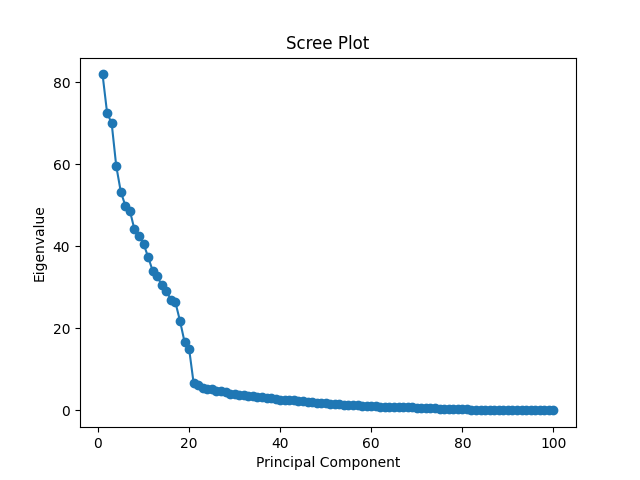

In [146]:
# Determine a suitable choice of L using a scree plot.
# Compute the eigenvalues of the covariance matrix of the training data
cov_matrix = np.cov(X, rowvar=False)
eigenvalues, _ = np.linalg.eigh(cov_matrix)

# Sort eigenvalues in descending order
eigenvalues = np.flip(np.sort(eigenvalues))

# Plot the scree plot
plt.figure()
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.title('Scree Plot')
plt.show()


Between 20 and 21, the largest kink is observed, suggesting that the number of used latent variables is likely 20.

In [147]:
# Determine a suitable choice of L using validation data.
split = len(X) * 3 // 4
X_train = X[:split,]
X_valid = X[split:,]

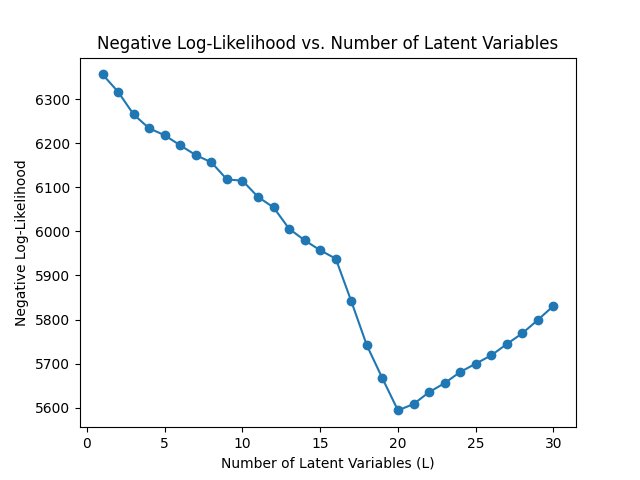

The optimal number of latent variables (L) is: 20


In [148]:
# YOUR CODE HERE
# Check the assumption on the number of latent variables using validation data
nlls = []
L_values = range(1, 31)  # Check for L values from 1 to 30

for L in L_values:
    model = ppca_mle(X_train, L)
    nll = ppca_nll(X_valid, model)
    nlls.append(nll)

# Plot the negative log-likelihoods for different L values
plt.figure()
plt.plot(L_values, nlls, marker='o')
plt.xlabel('Number of Latent Variables (L)')
plt.ylabel('Negative Log-Likelihood')
plt.title('Negative Log-Likelihood vs. Number of Latent Variables')
plt.show()

# Determine the optimal number of latent variables
optimal_L = L_values[np.argmin(nlls)]
print(f"The optimal number of latent variables (L) is: {optimal_L}")

### Evaluation of the Optimal Number of Latent Variables (L)

In this section, we aim to determine the optimal number of latent variables (L) for our probabilistic PCA model. We approach this task using two methods:
1. Studying the scree plot.
2. Using validation data.

#### (i) Studying the Scree Plot

The scree plot is a graphical representation of the eigenvalues of the covariance matrix of the data. It helps us identify the number of principal components that capture the most variance in the data. The plot typically shows a sharp decline in eigenvalues, followed by a plateau. The point where the decline slows down is often considered the optimal number of latent variables.

In our scree plot, we observed a significant kink between the 20th and 21st eigenvalues. This suggests that the first 20 principal components capture most of the variance in the data, and adding more components beyond this point yields diminishing returns.

#### (ii) Using Validation Data

To validate our choice of L, we split the data into training and validation sets. We then computed the negative log-likelihood (NLL) for different values of L on the validation set. The NLL measures how well the model fits the data, with lower values indicating a better fit.

We plotted the NLL against the number of latent variables (L) and observed that the NLL reached its minimum at L = 20. This indicates that the model with 20 latent variables provides the best fit to the validation data.

#### Comparison of Results

Both methods—studying the scree plot and using validation data—converged on the same conclusion: the optimal number of latent variables (L) is 20. This agreement between the two methods strengthens our confidence in the result.

#### Conclusion

Based on the scree plot and validation data, we conclude that the optimal number of latent variables (L) for our probabilistic PCA model is 20. This choice balances the trade-off between model complexity and the ability to capture the underlying structure of the data.

# 2 Gaussian Mixture Models

## 2a) Toy data

In [149]:
# You do not need to modify this function.
def gmm_gen(N, mu, pi, Sigma=None, seed=None):
    """Generate data from a given GMM model.

    `N` is the number of data points to generate. `mu` and `Sigma` are lists with `K`
    elements holding the mean and covariance matrix of each mixture component. `pi` is a
    `K`-dimensional probability vector of component sizes.

    If `Sigma` is unspecified, a default (random) choice is taken.
    """
    K = len(pi)
    D = len(mu[0])
    rng = np.random.RandomState(seed)
    if Sigma is None:
        Sigma = [
            Q.transpose() @ np.diag([(k + 1) ** 2, k + 1]) @ Q
            for k, Q in enumerate([scipy.stats.ortho_group.rvs(2, random_state=rng) for k in range(K)])
        ]

    components = rng.choice(range(K), p=pi, size=N)
    X = np.zeros([N, D])
    for k in range(K):
        indexes = components == k
        N_k = np.sum(indexes.astype(np.int_))
        if N_k == 0:
            continue

        dist = scipy.stats.multivariate_normal(mean=mu[k], cov=Sigma[k], seed=rng)
        X[indexes, :] = dist.rvs(size=N_k)

    return dict(X=X, components=components, mu=mu, Sigma=Sigma, pi=pi)

-4380876.753061278


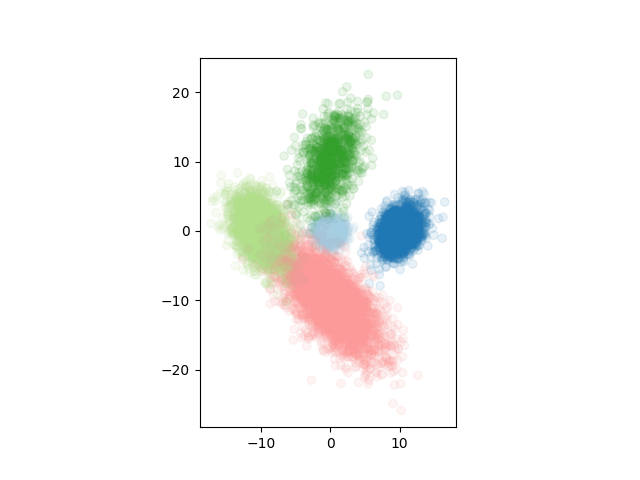

In [150]:
# Generate a toy dataset and plot it.
toy_gmm = gmm_gen(
    10000,
    [
        np.array([0, 0]),
        np.array([10, 0]),
        np.array([-10, 0]),
        np.array([0, 10]),
        np.array([0, -10]),
    ],
    np.array([0.1, 0.2, 0.25, 0.1, 0.35]),
    seed=4,
)

print(np.sum(toy_gmm["X"] ** 3))  # must be -4380876.753061278

plot_xy(toy_gmm["X"][:, 0], toy_gmm["X"][:, 1], toy_gmm["components"], alpha=0.1)

### Plot Description and Analysis

The dataset displayed in the plot was generated using a Gaussian Mixture Model (GMM). The GMM consists of five components, each defined by a mean vector, a covariance matrix, and a mixture proportion. The code creates these clusters by sampling points from multivariate normal distributions. 

### GMM Parameters:
1. **Number of points**: The dataset contains 10,000 points.
2. **Means of the clusters**:
   - Cluster 1: [0, 0]
   - Cluster 2: [10, 0]
   - Cluster 3: [-10, 0]
   - Cluster 4: [0, 10]
   - Cluster 5: [0, -10]
3. **Proportions of each cluster (π)**:
   - Cluster 1: 0.1
   - Cluster 2: 0.2
   - Cluster 3: 0.25
   - Cluster 4: 0.1
   - Cluster 5: 0.35
4. **Covariance matrices**: If not specified (as in this case), random covariance matrices are generated. This randomness introduces different spreads and orientations for each cluster.

### Key Observations from the Plot
The plot reveals five distinct clusters, each with unique characteristics in size, orientation, and density. Below is a detailed description of each cluster:

1. **Pink Cluster**:
   - **Location**: The cluster is situated roughly between -10 and 10 on the x-axis and -2 to -20 on the y-axis.
   - **Shape and Orientation**: It is elongated diagonally from the top-left to the bottom-right.
   - **Density**: This is the largest and densest cluster, representing 35% of the total data points (as per the GMM's π).

2. **Light Green Cluster**:
   - **Location**: Found between -15 and -5 on the x-axis and -7 to 7 on the y-axis.
   - **Shape and Orientation**: Its structure aligns with the direction of the pink cluster, appearing as an extension. 
   - **Density**: Slightly less dense compared to the pink cluster, representing 25% of the data points.

3. **Light Blue Cluster**:
   - **Location**: Centered near the origin ([0, 0]) with a radius of approximately 3.
   - **Shape and Orientation**: It is circular and isotropic, unlike the other clusters.
   - **Density**: This is the smallest cluster, corresponding to only 10% of the data points.

4. **Dark Blue Cluster**:
   - **Location**: Positioned between 5 and 15 on the x-axis and -5 to 5 on the y-axis.
   - **Shape and Orientation**: This cluster is rotated differently from others and oriented diagonally from the bottom-left to the top-right. It is slightly more compressed compared to the light green cluster.
   - **Density**: Represents 20% of the dataset.

5. **Dark Green Cluster**:
   - **Location**: The core lies between -5 and 5 on the x-axis and 5 to 15 on the y-axis.
   - **Shape and Orientation**: The cluster is vertically elongated but slightly rotated from the bottom-left to the top-right.
   - **Density**: This cluster is the least dense and most spread-out among all, corresponding to 10% of the data points.
   

### Connection Between Code and Plot

1. **Cluster Locations (Means)**:
   - The means defined in the code (`mu`) directly determine the central positions of the clusters in the plot:
     - `[0, 0]` corresponds to the **light blue circular cluster** at the origin.
     - `[10, 0]` corresponds to the **dark blue diagonal cluster** on the right side of the plot.
     - `[-10, 0]` corresponds to the **light green diagonal cluster** on the left side of the plot.
     - `[0, 10]` corresponds to the **dark green vertically elongated cluster** near the top.
     - `[0, -10]` corresponds to the **pink elongated cluster** near the bottom.

2. **Cluster Sizes (Proportions, π)**:
   - The proportions (`pi`) in the code influence the relative sizes (densities) of the clusters:
     - The **pink cluster** is the largest, aligning with the highest proportion (`0.35`).
     - The **light green cluster** is the second-largest, matching its proportion (`0.25`).
     - The **dark blue cluster** is intermediate in size, reflecting its proportion (`0.2`).
     - The **dark green cluster** and **light blue cluster** are smaller, consistent with their lower proportions (`0.1` each).

3. **Cluster Shapes and Orientations (Covariance Matrices, Σ)**:
   - The covariance matrices (`Sigma`) define the shapes and orientations of each cluster:
     - The **pink cluster's diagonal orientation** and large spread are explained by its covariance structure, which generates a top-left to bottom-right elongation.
     - The **light green cluster's diagonal alignment**, extending in a similar direction, arises from a covariance matrix with similar orientation but less spread.
     - The **dark blue cluster's diagonal alignment**, running bottom-left to top-right, reflects a rotated and slightly compressed covariance structure.
     - The **dark green cluster's vertical elongation**, with slight rotation, is due to a covariance matrix emphasizing vertical spread.
     - The **light blue cluster's circular shape** matches an isotropic covariance structure.

4. **Density and Distribution**:
   - The random sampling process (`N_k` points per cluster based on proportions and random seed) ensures the clusters' sizes in the plot mirror the proportions provided in the code. The visible density differences, especially the sparsity of the dark green cluster, directly result from its low proportion and high spread.

The GMM generates a diverse dataset with clusters varying in size, shape, orientation, and density, as illustrated in the plot. The largest cluster (pink) dominates the visual spread, while the smallest (light blue) remains compact and isotropic. The light green and dark blue clusters add intermediate levels of density and unique directional characteristics. Finally, the dark green cluster stands out as the most spread and least dense, further diversifying the visual complexity of the data.

## 2b) K-Means

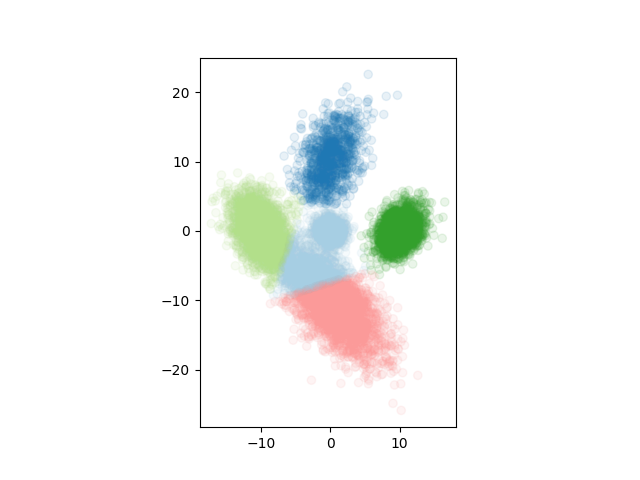

In [151]:
# Fit 5 clusters using k-means.
kmeans = KMeans(5).fit(toy_gmm["X"])
plot_xy(toy_gmm["X"][:, 0], toy_gmm["X"][:, 1], kmeans.labels_, alpha=0.1)

# Comparison of Gaussian Mixture Model (GMM) and K-Means Clustering

## GMM Plot and K-Means Plot: Visual Comparison and Analysis
The GMM and K-Means clustering results are compared to evaluate how well K-Means reproduces the original GMM structure. While both methods generate five clusters, there are notable differences in the cluster shapes, sizes, and boundaries due to the fundamental differences in the clustering algorithms.

### Key Observations:
1. **Clusters That Are Similar**:
   - The **dark blue cluster** and the **light green cluster** remain almost unchanged between the two plots. This similarity arises because these clusters have distinct and well-separated means and structures in the original GMM, which K-Means handles effectively.

2. **Clusters with Significant Differences**:
   - The **light blue cluster** in the K-Means plot now extends from the origin to the bottom-left corner. This extension merges parts of the original **pink cluster** and **light green cluster** into the new light blue cluster.
   - The **pink cluster** in the K-Means plot is smaller, as part of its data points have been reassigned to the **light blue cluster**.
   - The boundary between the original **pink cluster** and **light blue cluster** is now more horizontal. This change occurs because K-Means produces straight-line decision boundaries that are orthogonal to the feature space, unlike the flexible covariance-driven boundaries in GMM.

3. **Boundary Adjustments**:
   - The most noticeable change is the **diagonal decision boundary** between the original **pink cluster** and **light blue cluster**, cutting from the top-right to the bottom-left. This creates a sharp separation that includes overlapping points from both clusters into the new light blue cluster.
   - The **original light green cluster** boundary remains nearly intact, as its distinct separation and strong density prevent significant reassignment.

### Reasoning About Decision Boundaries:
The differences in decision boundaries result from the fundamental mechanisms of K-Means clustering:
- **K-Means** uses Euclidean distance to assign points to the nearest centroid, leading to **linear boundaries** between clusters.
- **GMM** assigns points based on a probabilistic model, allowing **elliptical or non-linear boundaries** that align more naturally with the data's underlying distribution.

In the K-Means plot:
- The **light blue cluster's extension** is a result of the centroid for this cluster being pulled toward the overlapping regions. Consequently, points previously belonging to the **pink** and **light green clusters** are reassigned based on their proximity to this shifted centroid.
- The **smaller pink cluster** reflects the more compact reassignment caused by K-Means' inability to model the elongated shape of the original GMM cluster.

## Connection Between Code and K-Means Results
1. **Centroids Initialization**:
   - The GMM means (`mu`) act as the starting point for the centroids in K-Means. However, as K-Means iterates, centroids shift to minimize intra-cluster variance. This shift explains why the light blue cluster absorbs points from other clusters—it moves toward the denser overlapping regions.

2. **Cluster Sizes**:
   - The proportions (`pi`) in the GMM influence initial cluster densities, but K-Means does not explicitly account for proportions. Instead, cluster sizes in K-Means are determined by the density and proximity of points to each centroid.

3. **Shape and Boundaries**:
   - The covariance matrices (`Sigma`) in GMM allow for flexible, elliptical boundaries, whereas K-Means imposes straight-line boundaries. This rigidity in K-Means leads to artificial splits, such as the diagonal and horizontal separations observed in the plot.

### Conclusion:
While K-Means captures the general structure of the GMM clusters, it struggles with clusters that overlap significantly or have elongated, non-circular shapes. The differences in the light blue and pink clusters highlight how K-Means’ linear decision boundaries reshape the original clusters, often diminishing accuracy in favor of simplicity.

## 2c) Fit a GMM

In [ ]:
def gmm_e(X, model, return_F=False):
    """Perform the E step of EM for a GMM (MLE estimate).

    `model` is a dictionary holding model parameters (keys `mu`, `Sigma`, and `pi`
    defined as in `gmm_gen`).

    Returns a NxK matrix of cluster membership probabilities. If `return_F` is true,
    also returns an NxK matrix holding the density of each data point (row) for each
    component (column).

    """
    mu, Sigma, pi = model["mu"], model["Sigma"], model["pi"]
    N, D = X.shape
    K = len(pi)

    # YOUR CODE HERE

    F = np.zeros((N, K))

    for k in range(K):
        dist = scipy.stats.multivariate_normal(mean=mu[k], cov=Sigma[k])
        F[:, k] = dist.pdf(X)
    
    W = F * pi
    W /= W.sum(axis=1, keepdims=True)

    # all done
    if return_F:
        return W, F
    else:
        return W

In [153]:
# Test your solution. This should produce:
# (array([[9.99999999e-01, 8.65221693e-10, 1.59675131e-23, 1.14015011e-41, 2.78010004e-65],
        # [1.00000000e+00, 3.75078862e-12, 1.55035521e-23, 1.28102693e-34, 1.86750812e-46],
        # [9.99931809e-01, 6.81161224e-05, 7.23302032e-08, 2.17176125e-09, 1.62736835e-10]]),
 # array([[1.71811600e-08, 5.94620494e-18, 1.82893598e-31, 9.79455071e-50, 1.59217812e-73],
        # [1.44159783e-15, 2.16285148e-27, 1.48999246e-38, 9.23362817e-50, 8.97398547e-62],
        # [1.85095927e-09, 5.04355064e-14, 8.92595932e-17, 2.01005787e-18, 1.00413265e-19]]))
dummy_model = dict(
    mu=[np.array([k, k + 1]) for k in range(5)],
    Sigma=[np.array([[3, 1], [1, 2]]) / (k + 1) for k in range(5)],
    pi=np.array([0.1, 0.25, 0.15, 0.2, 0.3]),
)
gmm_e(toy_gmm["X"][:3,], dummy_model, return_F=True)

(array([[9.99999999e-01, 8.65221693e-10, 1.59675131e-23, 1.14015011e-41,
         2.78010004e-65],
        [1.00000000e+00, 3.75078862e-12, 1.55035521e-23, 1.28102693e-34,
         1.86750812e-46],
        [9.99931809e-01, 6.81161224e-05, 7.23302032e-08, 2.17176125e-09,
         1.62736835e-10]]),
 array([[1.71811600e-08, 5.94620494e-18, 1.82893598e-31, 9.79455071e-50,
         1.59217812e-73],
        [1.44159783e-15, 2.16285148e-27, 1.48999246e-38, 9.23362817e-50,
         8.97398547e-62],
        [1.85095927e-09, 5.04355064e-14, 8.92595932e-17, 2.01005787e-18,
         1.00413265e-19]]))

In [160]:
def gmm_m(X, W):
    """Perform the M step of EM for a GMM (MLE estimate).

    `W` is the NxK cluster membership matrix computed in the E step. Returns a new model
    (dictionary with keys `mu`, `Sigma`, and `pi` defined as in `gmm_gen`).

    """
    N, D = X.shape
    K = W.shape[1]

    # YOUR CODE HERE

    # Compute the mixture weights
    pi = np.mean(W, axis=0)

    # Compute the means
    mu = np.dot(W.T, X) / np.sum(W, axis=0)[:, np.newaxis]

    # Compute the covariances
    Sigma = []
    for k in range(K):
        X_centered = X - mu[k]
        W_diag = np.diag(W[:, k])
        Sigma_k = np.dot(X_centered.T, np.dot(W_diag, X_centered)) / np.sum(W[:, k])
        Sigma.append(Sigma_k)

    return dict(mu=mu, Sigma=Sigma, pi=pi)

In [161]:
# Test your solution. This should produce:
# {'mu': [array([ 6.70641574, -0.47971125]),
#   array([8.2353509 , 2.52134815]),
#   array([-3.0476848 , -1.70722161])],
#  'Sigma': [array([[88.09488652, 11.08635139],
#          [11.08635139,  1.39516823]]),
#   array([[45.82761873, 11.38773232],
#          [11.38773232,  6.87352224]]),
#   array([[98.6662729 , 12.41671355],
#          [12.41671355,  1.56258842]])],
#  'pi': array([0.13333333, 0.53333333, 0.33333333])}
gmm_m(toy_gmm["X"][:3,], np.array([[0.1, 0.2, 0.7], [0.3, 0.4, 0.3], [0.0, 1.0, 0.0]]))

{'mu': array([[ 6.70641574, -0.47971125],
        [ 8.2353509 ,  2.52134815],
        [-3.0476848 , -1.70722161]]),
 'Sigma': [array([[88.09488652, 11.08635139],
         [11.08635139,  1.39516823]]),
  array([[45.82761873, 11.38773232],
         [11.38773232,  6.87352224]]),
  array([[98.6662729 , 12.41671355],
         [12.41671355,  1.56258842]])],
 'pi': array([0.13333333, 0.53333333, 0.33333333])}

In [156]:
# you do not need to modify this method
def gmm_fit(X, K, max_iter=100, mu0=None, Sigma0=None, pi0=None, gmm_m=gmm_m):
    """Fit a GMM model using EM.

    `K` refers to the number of mixture components to fit. `mu0`, `Sigma0`, and `pi0`
    are initial parameters (automatically set when unspecified).

    """
    N, D = X.shape

    if mu0 is None:
        mu0 = [np.random.randn(D) for k in range(K)]
    if Sigma0 is None:
        Sigma0 = [np.eye(D) * 10 for k in range(K)]
    if pi0 is None:
        pi0 = np.ones(K) / K

    model = dict(mu=mu0, Sigma=Sigma0, pi=pi0)
    for it in range(max_iter):
        W = gmm_e(X, model)
        model = gmm_m(X, W)

    return model

## 2d+2e) Experiment with GMMs for the toy data

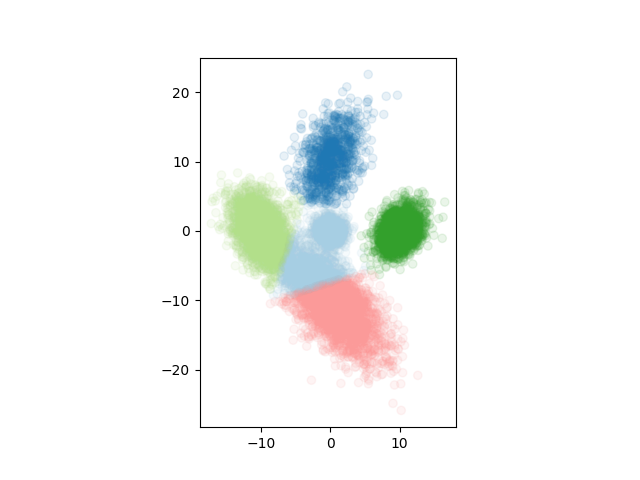

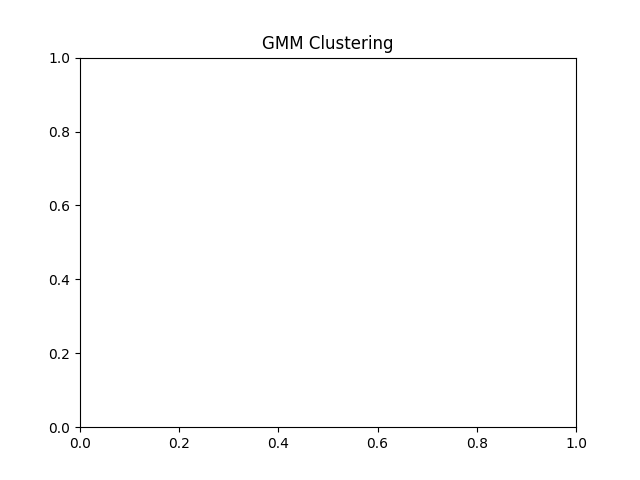

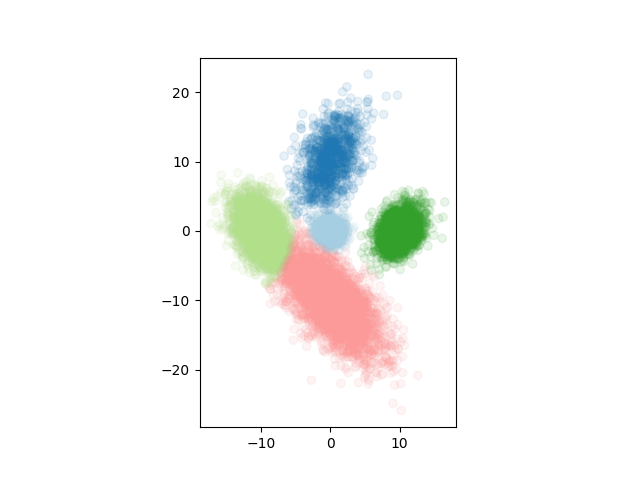

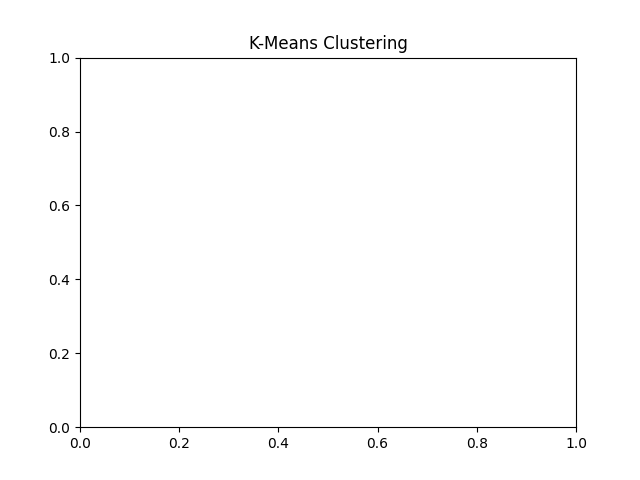

In [157]:
# Fit on toy data and color each point by most likely component. Also try fitting with 4
# or 6 components.
toy_gmm_fit = gmm_fit(toy_gmm["X"], 5)

# Assign each data point to its most likely component
W, F = gmm_e(toy_gmm["X"], toy_gmm_fit, return_F=True)
most_likely_component = np.argmax(W, axis=1)

# Plot the dataset with the GMM clustering
plt.figure()
plt.title("GMM Clustering")
plot_xy(toy_gmm["X"][:, 0], toy_gmm["X"][:, 1], most_likely_component, alpha=0.1)

# Compare with K-Means clustering
plt.figure()
plt.title("K-Means Clustering")
plot_xy(toy_gmm["X"][:, 0], toy_gmm["X"][:, 1], kmeans.labels_, alpha=0.1)

plt.show()

## 2f) Discover the Secret (optional)

In [158]:
# Load the secret data.
X = np.loadtxt("data/secret_gmm.csv", delimiter=",")

In [159]:
# How many components are hidden in this data?